# Pathology Image Classification Comparison

## Setup and dependencies

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold # For creating a validation set, grid search and cross-validation
from sklearn.model_selection import ParameterGrid # For grid search
from sklearn.ensemble import RandomForestClassifier # For Random Forest
from sklearn import metrics # For evaluation metrics
from sklearn.metrics import accuracy_score, f1_score # For accuracy score, f1-score
import tensorflow as tf 
from tensorflow import keras
import keras_tuner # For hyperparameter tuning in MLP, CNN
from keras_tuner import BayesianOptimization # For Bayesian optimisation tuning
from keras.callbacks import EarlyStopping # For stop training when a monitored metric has stopped improving.
import time #For runtime measurements
import matplotlib.pyplot as plt
import seaborn as sns

# Make the notebook's output stable across runs
np.random.seed(42)
keras.backend.clear_session()
tf.random.set_seed(42)

# Function to plot image examples from the dataset
def plot_examples(data, n_rows=4, n_cols=10):
    """Plot a grid of images which are encoded as numpy arrays."""
    if data.shape[-1] == 1:
        data = data.squeeze(axis=-1)        
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    for row in range(n_rows):
        for col in range(n_cols):
            # Get next index of image
            index = n_cols * row + col
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
    plt.show()

## 1. Data loading, exploration, and preprocessing


(1) Data Exploration

In [9]:
# Load the dataset training and test sets as numpy arrays
X_train = np.load('Data/X_train.npy')
y_train = np.load('Data/y_train.npy')
X_test = np.load('Data/X_test.npy')
y_test = np.load('Data/y_test.npy')

In [10]:
# Print the shape of training and test set
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (32000, 28, 28, 3)
Shape of y_train: (32000,)
Shape of X_test: (8000, 28, 28, 3)
Shape of y_test: (8000,)


In [11]:
# Check the data type of X
print(X_train.dtype)
print(X_test.dtype)

uint8
uint8


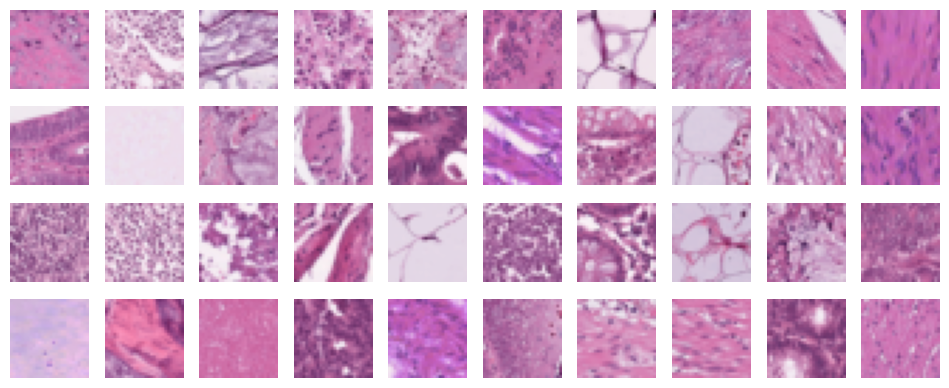

In [12]:
# Display image examples using the function predefined
plot_examples(X_train)

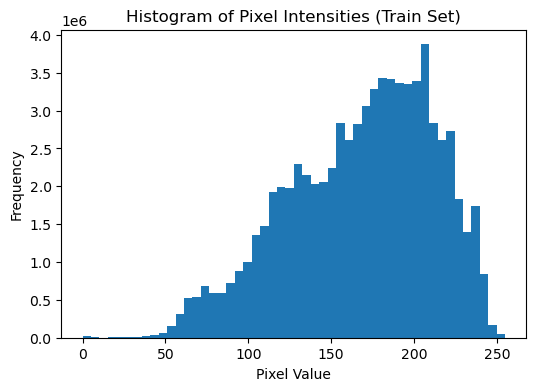

Mean pixel intensity: 168.2138
Std pixel intensity: 43.7162


In [13]:
# Pixel intensity across different images in training set
plt.figure(figsize=(6, 4))
plt.hist(X_train.flatten(), bins=50)
plt.title("Histogram of Pixel Intensities (Train Set)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

print(f"Mean pixel intensity: {X_train.mean():.4f}")
print(f"Std pixel intensity: {X_train.std():.4f}")

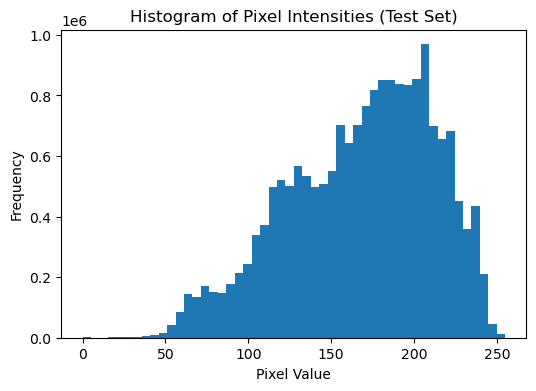

Mean pixel intensity: 168.1211
Std pixel intensity: 43.8527


In [14]:
# Pixel intensity across different images in test set
plt.figure(figsize=(6, 4))
plt.hist(X_test.flatten(), bins=50)
plt.title("Histogram of Pixel Intensities (Test Set)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

print(f"Mean pixel intensity: {X_test.mean():.4f}")
print(f"Std pixel intensity: {X_test.std():.4f}")

Class labels in y_train: [0 1 2 3 4 5 6 7 8]
Number of examples from each class: [3490 3431 3505 3656 2950 4290 2728 3253 4697]


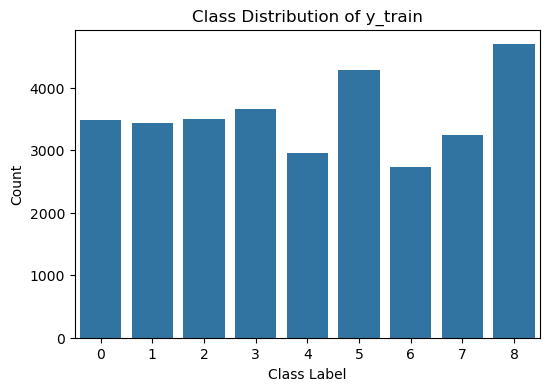

In [15]:
# List all unique labels in the training set
train_unique_class, train_class_counts = np.unique(y_train, return_counts = True)
print(f"Class labels in y_train: {train_unique_class}")
print(f"Number of examples from each class: {train_class_counts}")

# Visualise class distribution of training set 
plt.figure(figsize = (6, 4))
sns.barplot(x = train_unique_class, y = train_class_counts)
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Distribution of y_train")
plt.show()

Class labels in y_test: [0 1 2 3 4 5 6 7 8]
Number of examples from each class: [ 873  858  877  914  737 1072  682  813 1174]


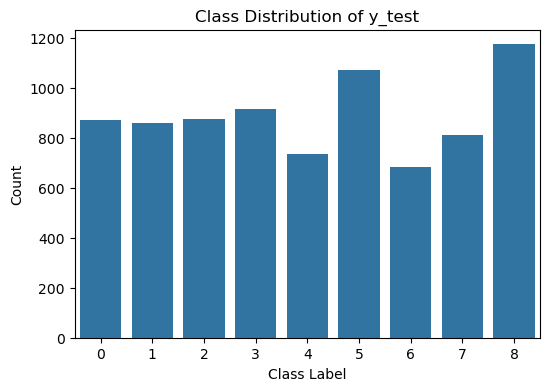

In [16]:
# List all unique labels in the test set
test_unique_class, test_class_counts = np.unique(y_test, return_counts = True)
print(f"Class labels in y_test: {test_unique_class}")
print(f"Number of examples from each class: {test_class_counts}")

# Visualise the class distribution of test set
plt.figure(figsize = (6, 4))
sns.barplot(x = test_unique_class, y = test_class_counts)
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Distribution of y_test")
plt.show()

Class 0 example:


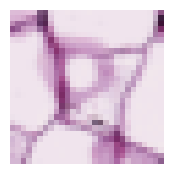

Class 1 example:


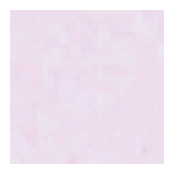

Class 2 example:


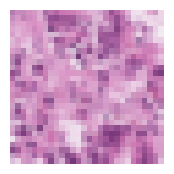

Class 3 example:


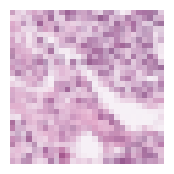

Class 4 example:


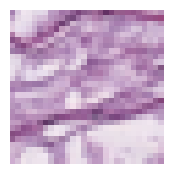

Class 5 example:


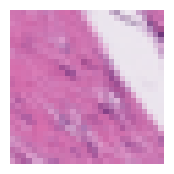

Class 6 example:


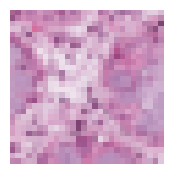

Class 7 example:


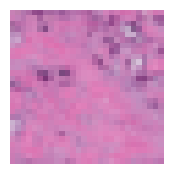

Class 8 example:


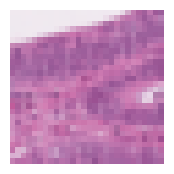

In [17]:
# Display one example image per class
classes = np.unique(y_train)

for cls in classes:
    index = np.where(y_train == cls)[0][0]
    image = X_train[index]
    
    print(f"Class {cls} example:")
    plt.figure(figsize=(2, 2))
    plt.imshow(image, cmap='gray' if image.ndim == 2 else None)
    plt.axis("off")
    plt.show()


(2) Data Preprocessing

In [19]:
# Scale the data to the range 0-1
X_train = X_train / 255.
X_test = X_test / 255.

In [20]:
# Create a validation set for MLP and CNN, setting aside 10% of the original training data
X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train, y_train, train_size=0.9, stratify = y_train, random_state = 42)

In [21]:
# Flatten the attributes for random forest
X_train_full_flat = X_train.reshape((X_train.shape[0], -1))
X_train_flat = X_train_split.reshape((X_train_split.shape[0], -1))
X_valid_flat = X_valid.reshape((X_valid.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

### Examples of preprocessed data

In [650]:
# Check the shape of data after preprocessing
print(f"Shape of X_train_split: {X_train_split.shape}")
print(f"Shape of X_valid: {X_valid.shape}")
print(f"Shape of X_test: {X_test.shape}")

print(f"Shape of X_train_full_flat: {X_train_full_flat.shape}")
print(f"Shape of X_train_flat: {X_train_flat.shape}")
print(f"Shape of X_valid_flat: {X_valid_flat.shape}")
print(f"Shape of X_test_flat: {X_test_flat.shape}")

Shape of X_train_split: (28800, 28, 28, 3)
Shape of X_valid: (3200, 28, 28, 3)
Shape of X_test: (8000, 28, 28, 3)
Shape of X_train_full_flat: (32000, 2352)
Shape of X_train_flat: (28800, 2352)
Shape of X_valid_flat: (3200, 2352)
Shape of X_test_flat: (8000, 2352)


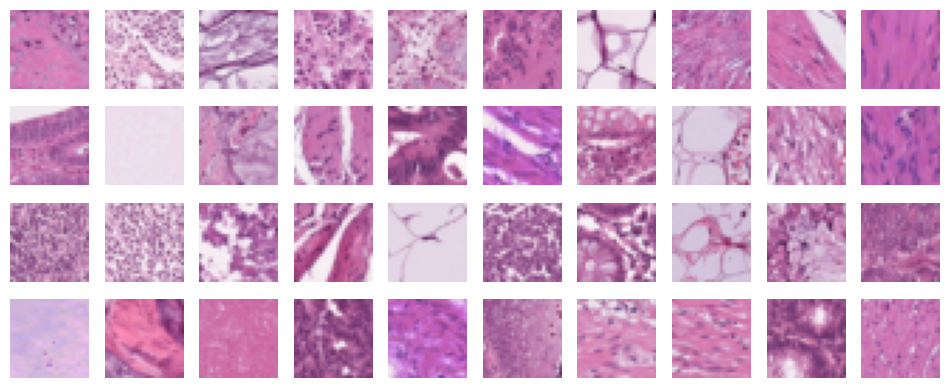

In [642]:
# Check image examples after scaling
plot_examples(X_train)

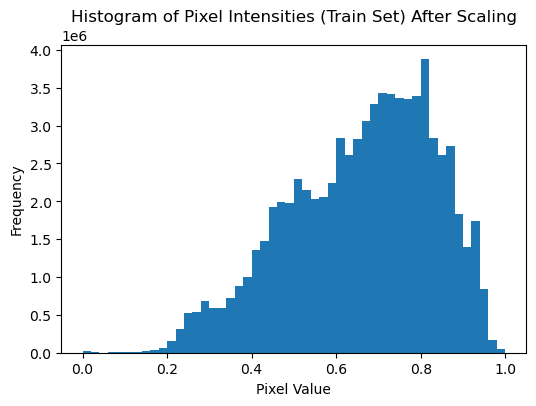

Mean pixel intensity: 0.6597
Std pixel intensity: 0.1714


In [646]:
# Check pixel intensity and pixel value range after scaling
plt.figure(figsize=(6, 4))
plt.hist(X_train.flatten(), bins=50)
plt.title("Histogram of Pixel Intensities (Train Set) After Scaling")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

print(f"Mean pixel intensity: {X_train.mean():.4f}")
print(f"Std pixel intensity: {X_train.std():.4f}")

## 2. Algorithm design and setup

### Random forest

In [302]:
# Random Forest Baseline Model
rf = RandomForestClassifier(criterion='entropy', n_estimators = 200, max_depth = 10, n_jobs = -1, random_state = 42)
rf.fit(X_train_flat, y_train_split)
print(f"Random forest accuracy: {accuracy_score(y_test, rf.predict(X_test_flat)):.4f}")

Random forest accuracy: 0.6016


In [303]:
# Experiment on n_estimators
for n in [50, 100, 300]:
    rf_test = RandomForestClassifier(n_estimators = n, max_depth = 10, n_jobs = -1, random_state=42)
    rf_test.fit(X_train_flat, y_train_split)
    acc = accuracy_score(y_test, rf_test.predict(X_test_flat))
    print(f"n_estimators = {n}, accuracy = {acc:.4f}")
# Experiment on max_depth
for n in [5, 15, 20]:
    rf_test = RandomForestClassifier(n_estimators = 200, max_depth = n, n_jobs = -1, random_state=42)
    rf_test.fit(X_train_flat, y_train_split)
    acc = accuracy_score(y_test, rf_test.predict(X_test_flat))
    print(f"max_depth = {n}, accuracy = {acc:.4f}")

n_estimators = 50, accuracy = 0.5935
n_estimators = 100, accuracy = 0.5995
n_estimators = 300, accuracy = 0.6044
max_depth = 5, accuracy = 0.4620
max_depth = 15, accuracy = 0.6479
max_depth = 20, accuracy = 0.6506


In [35]:
# Hyparameter tuning function for random forest
def bestRFClassifier(X_train_flat, X_test_flat, y_train, y_test, param_grid):
    # Perform grid search with 5-fold cross-validation for Random Forest with information gain and max_features
    grid_search = GridSearchCV(RandomForestClassifier(criterion = "entropy", n_jobs = -1, random_state = 42), 
                               param_grid, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42))
    grid_search.fit(X_train_flat, y_train) #Use training data to train the classifier
    
    # Create a DataFrame summarizing the grid search results
    rf_tuning_summary = pd.DataFrame(grid_search.cv_results_)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    return [best_params, best_score, rf_tuning_summary] # Return best parameters and cross-validation results

### Fully connected neural network

In [306]:
# MLP Baseline model
mlp = keras.models.Sequential([
    keras.layers.Input([28, 28, 3]),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation = "relu"),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(9, activation = "softmax")
])

# Compile the model.
mlp.compile(loss = "sparse_categorical_crossentropy", optimizer = keras.optimizers.Adam(learning_rate = 0.001), metrics = ["accuracy"])

# Train the classifier.
history_mlp = mlp.fit(X_train_split, y_train_split, epochs = 20, validation_data=(X_valid, y_valid), 
                  callbacks=[keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights=True)])

# Evaluate the classifier on the test data.
loss_mlp, accuracy_mlp = mlp.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy_mlp:.4f}")

Epoch 1/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2425 - loss: 1.9992 - val_accuracy: 0.3675 - val_loss: 1.7062
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3851 - loss: 1.6217 - val_accuracy: 0.4384 - val_loss: 1.5022
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4441 - loss: 1.4752 - val_accuracy: 0.5031 - val_loss: 1.3451
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4714 - loss: 1.4188 - val_accuracy: 0.4963 - val_loss: 1.3818
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4866 - loss: 1.3779 - val_accuracy: 0.5141 - val_loss: 1.3583
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4952 - loss: 1.3594 - val_accuracy: 0.5384 - val_loss: 1.3190
Epoch 7/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4984 - loss: 1.3426 - val_accuracy: 0.5394 - val_loss: 1.2856
Epoch 8/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5052 - loss: 1.3229 - val_accuracy: 0.

In [307]:
# Prepare a function for MLP hyperparameter tuning
def build_mlp_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape = [28, 28, 3]))
    model.add(keras.layers.Flatten())
    # Set up the number of hidden layers to be tuned over from 1 to 3
    num_hidden_layers = hp.Int("num_hidden_layers", min_value = 1, max_value = 3)
    for i in range(num_hidden_layers):
        # Set up the number of neurons per layer to be tuned over among [100, 128, 256, 300]
        model.add(keras.layers.Dense(units=hp.Choice(f"units_{i}", values=[100, 128, 256, 300]), activation="relu"))     
    model.add(keras.layers.Dense(9, activation = "softmax"))
    
    # Set up the learning rate values to be tuned over among [0.01, 0.001, 0.0001]
    learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

### Convolutional neural network

In [309]:
# CNN Baseline Model
cnn = keras.Sequential([ 
    # Specify the input shape
    keras.Input(shape=(28, 28, 3)),
    # Conv and pool block 1
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding = "same"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Conv and pool block 2
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding = "same"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Flatten and classify using dense output layer
    keras.layers.Flatten(),
    keras.layers.Dense(9, activation="softmax"),
])

# Compile model with loss, optimiser, and metrics
cnn.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# Train the model for 20 epochs with a default batch size 32
history_cnn = cnn.fit(X_train_split, y_train_split, epochs = 20, validation_data=(X_valid, y_valid), 
                  callbacks=[keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights=True)])

# Evaluate the classifier on the test data.
loss_cnn, accuracy_cnn = cnn.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy_cnn:.4f}")

Epoch 1/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.3902 - loss: 1.6211 - val_accuracy: 0.6225 - val_loss: 1.0642
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6200 - loss: 1.0349 - val_accuracy: 0.6303 - val_loss: 0.9687
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6858 - loss: 0.8607 - val_accuracy: 0.6728 - val_loss: 0.8676
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7236 - loss: 0.7708 - val_accuracy: 0.7013 - val_loss: 0.8031
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7484 - loss: 0.7065 - val_accuracy: 0.7328 - val_loss: 0.7233
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7673 - loss: 0.6583 - val_accuracy: 0.7547 - val_loss: 0.6714
Epoch 7/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7794 - loss: 0.6165 - val_accuracy: 0.7659 - val_loss: 0.6495
Epoch 8/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7891 - loss: 0.5862 - val_accuracy: 0.

In [310]:
# Prepare a function for CNN hyperparameter tuning
def build_cnn_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape = [28, 28, 3]))
    # Set up the number of CONV-RELU-POOL blocks to be tuned over from 1 to 2
    for i in range(hp.Int("conv_blocks", 1, 2)):
        # Convolutional layer
        model.add(keras.layers.Conv2D(
                filters=hp.Choice(f"filters_{i}", values=[32, 64, 128]), # Set up the filter size to be tuned over among [32, 64, 128]
                kernel_size = 3, activation = "relu", padding = "same"))
        # Pooling layer
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    # Fully connected layer
    model.add(keras.layers.Flatten())
    # Set up the dropout rate to be tuned over in [0.3, 0.5]
    model.add(keras.layers.Dropout(hp.Choice("dropout", [0.3, 0.5])))
    model.add(keras.layers.Dense(9, activation = "softmax"))
    # Set up the learning rate values to be tuned over among [0.01, 0.001, 0.0001]
    learning_rate = hp.Choice("learning_rate", values = [0.01, 0.001, 0.0001])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate = learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

In [37]:
# For fair comparison, the whole training set will be used for hyperparameter tuning for random forest
# Define the hyperparameter values to be tested during grid search
n_estimators = [100, 200, 300]
max_depth = [10, 15, 20]
class_weight = [None, "balanced"]
# Create a hyperparameter grid
param_grid_rf = {"n_estimators": n_estimators, "max_depth": max_depth, "class_weight": class_weight} #Create a parameter grid

# Perform hyperparameter tuning with grid search strategy and return the best hyperparameter, best cross-validation score and tuning summary
rf_tuning_start_time = time.time()
best_param_rf, best_score, rf_tuning_summary = bestRFClassifier(X_train_full_flat, X_test_flat, y_train, y_test, param_grid_rf)
rf_tuning_end_time = time.time()
rf_tuning_training_time = rf_tuning_end_time - rf_tuning_start_time
print(f"Hyperparameter total tuning time of random forest: {rf_tuning_training_time:.2f} seconds")


# Print the result of hyperparameter tuning
for key, value in best_param_rf.items():
    print(f"RF best {key}: {value}")
print("RF cross-validation accuracy: {:.4f}".format(best_score))

Hyperparameter total tuning time of random forest: 1863.01 seconds
RF best class_weight: None
RF best max_depth: 20
RF best n_estimators: 300
RF cross-validation accuracy: 0.6531


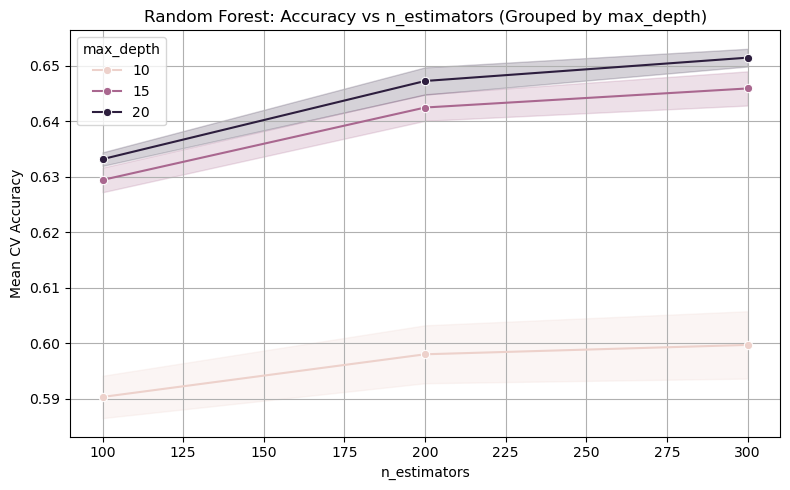

In [39]:
# Visualisation of hyperparameter tuning of random forest
# Visualise Accuracy vs n_estimators (Grouped by max_depth) for hyperparameter tuning of random forest
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=rf_tuning_summary,
    x="param_n_estimators",
    y="mean_test_score",
    hue="param_max_depth",
    marker="o"
)
plt.title("Random Forest: Accuracy vs n_estimators (Grouped by max_depth)")
plt.ylabel("Mean CV Accuracy")
plt.xlabel("n_estimators")
plt.grid(True)
plt.legend(title="max_depth")
plt.tight_layout()
plt.show()


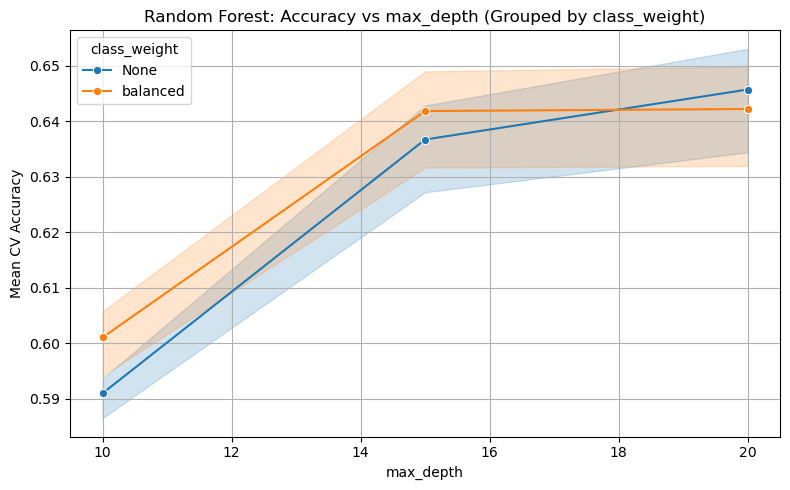

In [45]:
# Visualise Accuracy vs max_depth (Grouped by class_weight) for hyperparameter tuning of random forest
rf_tuning_summary["param_class_weight"] = rf_tuning_summary["param_class_weight"].astype(str)
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=rf_tuning_summary,
    x="param_max_depth",
    y="mean_test_score",
    hue="param_class_weight",
    marker="o"
)
plt.title("Random Forest: Accuracy vs max_depth (Grouped by class_weight)")
plt.ylabel("Mean CV Accuracy")
plt.xlabel("max_depth")
plt.grid(True)
plt.legend(title="class_weight")
plt.tight_layout()
plt.show()

### Fully connected neural network

In [357]:
# Perform hyperparameter tuning for MLP model using Bayesian optimisation
# Define the tuner
tuner_mlp = BayesianOptimization(
    hypermodel=build_mlp_model,
    objective="val_accuracy",
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory="keras_tuning_results",
    project_name="mlp_tuning")
# Run the hyperparameter search with early stopping based on validation loss
tuner_mlp.search(X_train_split, y_train_split, epochs=20, validation_data=(X_valid, y_valid), 
                 callbacks=[EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True)])
# Display the overview of the trials
tuner_mlp.results_summary()
# Print the best hyperparameters found
best_hps_mlp = tuner_mlp.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hps_mlp.values}")

Trial 50 Complete [00h 01m 29s]
val_accuracy: 0.5268750190734863

Best val_accuracy So Far: 0.6040624976158142
Total elapsed time: 01h 09m 54s
Results summary
Results in keras_tuning_results\mlp_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 16 summary
Hyperparameters:
num_hidden_layers: 3
units_0: 100
learning_rate: 0.001
units_1: 100
units_2: 128
Score: 0.6040624976158142

Trial 39 summary
Hyperparameters:
num_hidden_layers: 3
units_0: 100
learning_rate: 0.001
units_1: 100
units_2: 128
Score: 0.6018750071525574

Trial 01 summary
Hyperparameters:
num_hidden_layers: 3
units_0: 300
learning_rate: 0.001
units_1: 300
units_2: 100
Score: 0.6012499928474426

Trial 38 summary
Hyperparameters:
num_hidden_layers: 3
units_0: 100
learning_rate: 0.001
units_1: 100
units_2: 128
Score: 0.6003124713897705

Trial 17 summary
Hyperparameters:
num_hidden_layers: 3
units_0: 300
learning_rate: 0.001
units_1: 300
units_2: 100
Score: 0.6000000238418579

Trial 47 summary

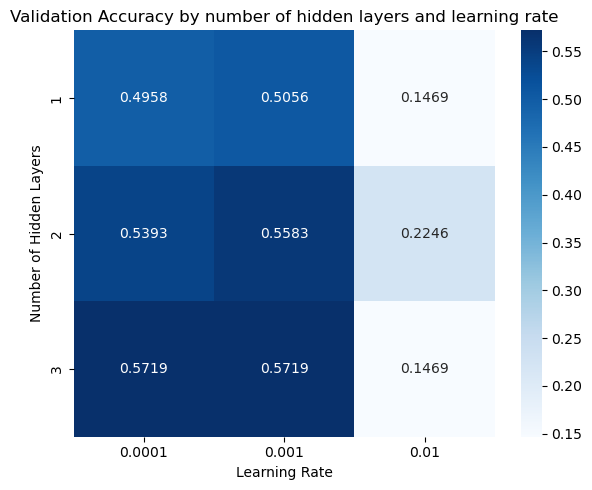

In [568]:
# Visualise validation accuracy by number of hidden layers and learning rate
# Retrieve all the trials' information
mlp_trials = tuner_mlp.oracle.get_best_trials(num_trials=50)

# Iterate all the trials to retrieve the hyperparameters and validation accuracy
mlp_trial_accuracy = []
for trial in mlp_trials:
    mlp_record = trial.hyperparameters.values.copy()
    mlp_record["val_accuracy"] = trial.score
    mlp_trial_accuracy.append(mlp_record)

# Create a DataFrame from the trial results for easy analysis
df_mlp = pd.DataFrame(mlp_trial_accuracy)

# Convert the relevant hyperparameters to string type for analysis
df_mlp["learning_rate"] = df_mlp["learning_rate"].astype(str)
df_mlp["num_hidden_layers"] = df_mlp["num_hidden_layers"].astype(int)

# Group the data by number of hidden layers and learning rate, and calculate the mean validation accuracy
# Prepare for visualise it as a heatmap
mlp_heatmap_data = df_mlp.groupby(["num_hidden_layers", "learning_rate"])["val_accuracy"].mean().unstack()

# Result visualisation
plt.figure(figsize=(6, 5))
sns.heatmap(mlp_heatmap_data, annot=True, fmt=".4f", cmap="Blues")
plt.title("Validation Accuracy by number of hidden layers and learning rate")
plt.xlabel("Learning Rate")
plt.ylabel("Number of Hidden Layers")
plt.tight_layout()
plt.show()

### Convolutional neural network

In [319]:
# Perform hyperparameter tuning for CNN model using Bayesian optimisation
# Define the tuner
tuner_cnn = keras_tuner.BayesianOptimization(
    hypermodel=build_cnn_model,
    objective="val_accuracy",  # optimize validation accuracy
    max_trials = 20,  # You can adjust the trials based on available time
    executions_per_trial=1,
    overwrite=True,
    directory="keras_tuning_results",
    project_name="cnn_tuning"
)
# Run the hyperparameter search with early stopping based on validation loss
tuner_cnn.search(X_train_split, y_train_split, epochs=20, validation_data=(X_valid, y_valid), 
                 callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
# Display the overview of the trials
tuner_cnn.results_summary()
# Print the best hyperparameters found
best_hps_cnn = tuner_cnn.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hps_cnn.values}")


Trial 20 Complete [00h 02m 03s]
val_accuracy: 0.7334374785423279

Best val_accuracy So Far: 0.8600000143051147
Total elapsed time: 00h 57m 17s
Results summary
Results in keras_tuning_results\cnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
conv_blocks: 2
filters_0: 64
dropout: 0.5
learning_rate: 0.001
filters_1: 128
Score: 0.8600000143051147

Trial 07 summary
Hyperparameters:
conv_blocks: 2
filters_0: 128
dropout: 0.3
learning_rate: 0.001
filters_1: 64
Score: 0.8496875166893005

Trial 09 summary
Hyperparameters:
conv_blocks: 2
filters_0: 32
dropout: 0.3
learning_rate: 0.001
filters_1: 64
Score: 0.8465625047683716

Trial 16 summary
Hyperparameters:
conv_blocks: 2
filters_0: 128
dropout: 0.5
learning_rate: 0.001
filters_1: 128
Score: 0.8446875214576721

Trial 00 summary
Hyperparameters:
conv_blocks: 2
filters_0: 128
dropout: 0.5
learning_rate: 0.001
filters_1: 32
Score: 0.8153125047683716

Trial 11 summary
Hyperparameter

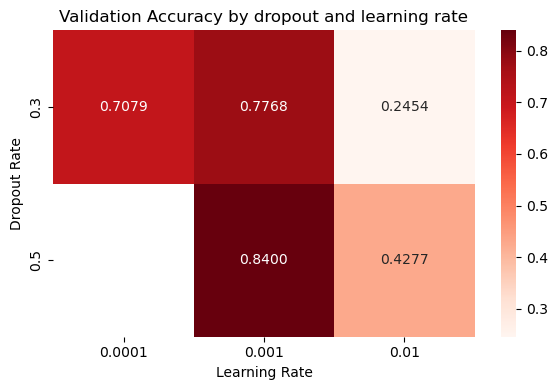

In [379]:
# Similar to what've done in MLP hyperparameter tuning to visualise validation accuracy by dropout rate and learning rate
# Retrieve all the trials' information
cnn_trials = tuner_cnn.oracle.get_best_trials(num_trials=20)

# Iterate all the trials to retrieve the hyperparameters and validation accuracy
cnn_trial_accuracy = []
for trial in cnn_trials:
    cnn_record = trial.hyperparameters.values.copy()
    cnn_record["val_accuracy"] = trial.score
    cnn_trial_accuracy.append(cnn_record)

# Create a DataFrame from the trial results for easy analysis
df_cnn = pd.DataFrame(cnn_trial_accuracy)

# Convert the relevant hyperparameters to string type for analysis
df_cnn["learning_rate"] = df_cnn["learning_rate"].astype(str)
df_cnn["dropout"] = df_cnn["dropout"].astype(str)

# Group the data by number of hidden layers and learning rate, and calculate the mean validation accuracy
# Prepare for visualise it as a heatmap
cnn_heatmap_data = df_cnn.groupby(["dropout", "learning_rate"])["val_accuracy"].mean().unstack()

# Result visualisation
plt.figure(figsize=(6, 4))
sns.heatmap(cnn_heatmap_data, annot=True, fmt=".4f", cmap="Reds")
plt.title("Validation Accuracy by dropout and learning rate")
plt.xlabel("Learning Rate")
plt.ylabel("Dropout Rate")
plt.tight_layout()
plt.show()

## 4. Final models

### Random forest

In [652]:
# Define the final random forest model with the best hyperparameters worked out above
rf_final = RandomForestClassifier(criterion='entropy', n_estimators = 300, max_depth = 20, class_weight = None, n_jobs = -1, random_state = 42)

# Record the training time of random forest training with the best hyperparameters
start_time = time.time()
rf_final.fit(X_train_flat, y_train_split)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time of random forest: {training_time:.2f} seconds")

# Predict on test set and print the accuracy
rf_final_y_pred = rf_final.predict(X_test_flat)
print(f"Random forest accuracy: {accuracy_score(y_test, rf_final_y_pred):.4f}")

# Calculate other performance measures - F1, precision and recall
print(metrics.classification_report(y_test, rf_final_y_pred))


Training time of random forest: 48.40 seconds
Random forest accuracy: 0.6605
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       873
           1       0.99      0.91      0.95       858
           2       0.69      0.33      0.44       877
           3       0.80      0.76      0.78       914
           4       0.51      0.67      0.58       737
           5       0.66      0.74      0.69      1072
           6       0.57      0.09      0.16       682
           7       0.51      0.48      0.49       813
           8       0.51      0.80      0.62      1174

    accuracy                           0.66      8000
   macro avg       0.67      0.64      0.62      8000
weighted avg       0.67      0.66      0.64      8000



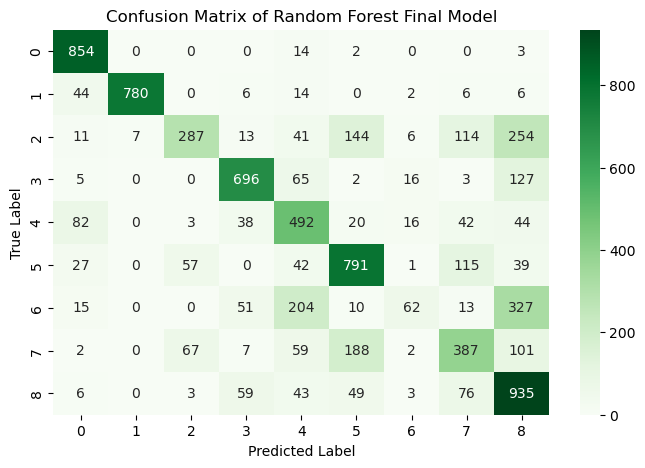

In [391]:
# Display confusion matrix for the final random forest model with heatmap
rf_final_cm = metrics.confusion_matrix(y_test, rf_final_y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(rf_final_cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Random Forest Final Model')
plt.show()

### Fully connected neural network

In [361]:
# Define the MLP final model layer by layer based on the hyperparameter tuning results
mlp_final = keras.models.Sequential([
    keras.layers.Input([28, 28, 3]),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dense(9, activation = "softmax")
])

# Compile the model.
mlp_final.compile(loss = "sparse_categorical_crossentropy", optimizer = keras.optimizers.Adam(learning_rate = 0.001), metrics = ["accuracy"])

# Train the classifier and record the training time
mlp_final_start_time = time.time()
history_mlp_final = mlp_final.fit(X_train_split, y_train_split, epochs = 20, validation_data=(X_valid, y_valid),
                                 callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True))
mlp_final_end_time = time.time()
mlp_final_training_time = mlp_final_end_time - mlp_final_start_time
print(f"Training time of MLP: {mlp_final_training_time:.2f} seconds")

# Evaluate the classifier on the test data.
loss_mlp_final, accuracy_mlp_final = mlp_final.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy_mlp_final:.4f}")

# Convert the class prediciton result from probabilities to class labels
mlp_final_y_pred = tf.argmax(mlp_final(X_test), axis=-1) 
# Calculate other performance measures - F1, precision and recall
print(metrics.classification_report(y_test, mlp_final_y_pred))

Epoch 1/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2694 - loss: 1.9010 - val_accuracy: 0.3919 - val_loss: 1.6120
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4126 - loss: 1.5499 - val_accuracy: 0.4600 - val_loss: 1.4173
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4789 - loss: 1.3877 - val_accuracy: 0.5141 - val_loss: 1.2870
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5021 - loss: 1.3232 - val_accuracy: 0.4931 - val_loss: 1.3145
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5150 - loss: 1.2723 - val_accuracy: 0.4909 - val_loss: 1.2901
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5247 - loss: 1.2398 - val_accuracy: 0.5256 - val_loss: 1.2087
Epoch 7/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5312 - loss: 1.2229 - val_accuracy: 0.5144 - val_loss: 1.2381
Epoch 8/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5432 - loss: 1.1876 - val_accuracy: 0.

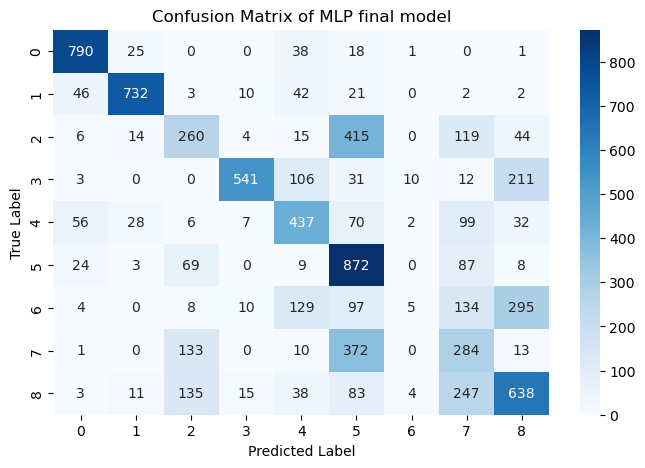

In [393]:
# Display confusion matrix for the final MLP model with heatmap
mlp_final_cm = metrics.confusion_matrix(y_test, mlp_final_y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(mlp_final_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of MLP final model')
plt.show()

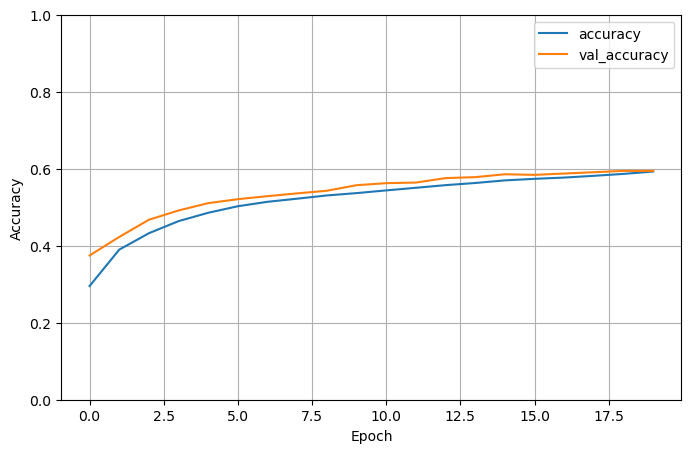

In [341]:
# Convert the history dictionary to a Pandas dataframe and extract the training and validation accuracies
mlp_final_accuracies = pd.DataFrame(history_mlp_final.history)[['accuracy', 'val_accuracy']]
# Plot the accuracies over epochs
mlp_final_accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Convolutional neural network

In [347]:
# Define the CNN final model layer by layer based on the hyperparameter tuning results
cnn_final = keras.Sequential([ 
    # Specify the input shape
    keras.Input(shape=(28, 28, 3)),
    # Conv and pool block 1
    keras.layers.Conv2D(64, kernel_size=3, activation="relu", padding = "same"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Conv and pool block 2
    keras.layers.Conv2D(128, kernel_size=5, activation="relu", padding = "same"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Flatten and classify using dense output layer
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(9, activation="softmax"),
])

# Compile model with loss, optimiser, and metrics
cnn_final.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model and record the training time
cnn_final_start_time = time.time()
history_cnn_final = cnn_final.fit(X_train_split, y_train_split, epochs = 20, validation_data=(X_valid, y_valid), 
                  callbacks=[keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights=True)])
cnn_final_end_time = time.time()
cnn_final_training_time = cnn_final_end_time - cnn_final_start_time
print(f"Training time of CNN: {cnn_final_training_time:.2f} seconds")

# Evaluate the classifier on the test data.
loss_cnn_final, accuracy_cnn_final = cnn_final.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy_cnn_final:.4f}")

# Convert the class prediciton result from probabilities to class labels
cnn_final_y_pred = tf.argmax(cnn_final(X_test), axis=-1)
# Calculate other performance measures - F1, precision and recall
print(metrics.classification_report(y_test, cnn_final_y_pred))

Epoch 1/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3802 - loss: 1.6276 - val_accuracy: 0.5997 - val_loss: 1.0552
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.6344 - loss: 0.9996 - val_accuracy: 0.6666 - val_loss: 0.9041
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.6841 - loss: 0.8709 - val_accuracy: 0.7141 - val_loss: 0.7734
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7113 - loss: 0.7959 - val_accuracy: 0.7331 - val_loss: 0.7191
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7269 - loss: 0.7480 - val_accuracy: 0.7328 - val_loss: 0.7294
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7482 - loss: 0.7002 - val_accuracy: 0.7534 - val_loss: 0.6875
Epoch 7/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7624 - loss: 0.6598 - val_accuracy: 0.7697 - val_loss: 0.6226
Epoch 8/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7672 - loss: 0.6342 - 

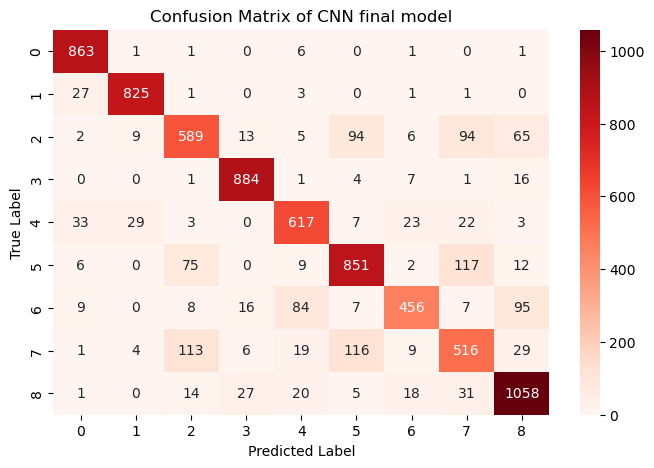

In [395]:
# Display confusion matrix for the final CNN model with heatmap
cnn_final_cm = metrics.confusion_matrix(y_test, cnn_final_y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cnn_final_cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of CNN final model')
plt.show()

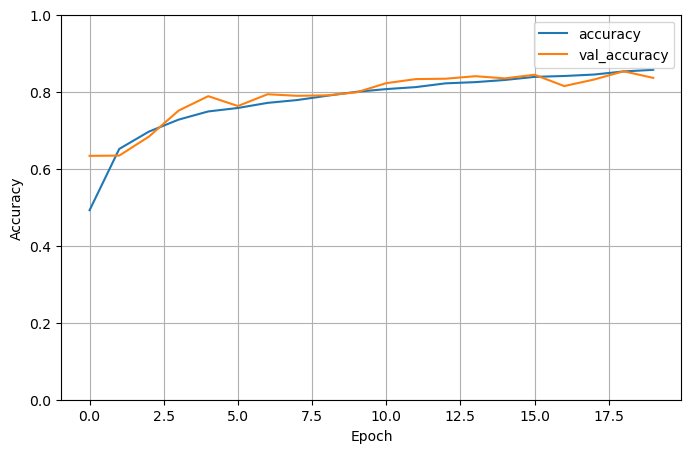

In [339]:
# Convert the history dictionary to a Pandas dataframe and extract the training and validation accuracies
cnn_final_accuracies = pd.DataFrame(history_cnn_final.history)[['accuracy', 'val_accuracy']]
# Plot the accuracies over epochs
cnn_final_accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()